# Finding the critical point and plotting the phase diagram
This notebook will find the critical point (up to a specified precision in $\mu$) for a given value of quark mass `ml` and chiral-dilaton coupling parameter `lambda1`.

This notebook uses the exponential parameterization of the dilaton,
$$\Phi(z) = -\mu_1^2z^2 + \left(\mu_0^2+\mu_1^2\right)z^2\left(1-e^{-\mu_2^2 z^2}\right)$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from criticalZoom import critical_zoom 
from timebudget import timebudget
import pandas as pd


## Search for the critical point

The critical point occurs at a particular value of chemical potential, $\mu_c$. If $\mu<\mu_c$, the phase transition is crossover. If $\mu>\mu_c$, the phase transition is first-order.

At each value of $\mu$ that we check, we need to find the transition temperature $T_c$, and also check if the transition is continuous (crossover), or discontinuous (1st-order). Each of these checks takes a long time, running the function `critical_zoom`. On the 20-core Mac Studio, each value of $\mu$ takes about a minute to check. It takes longer with fewer CPUs.

If we want to map the entire phase plot, we could check all values of $\mu$, at a spacing of about 5 MeV, from 0 to 1000. This takes a few hours on the Mac Studio. This program instead uses a binary search method to zoom in on the critical point more efficiently.

### Saving the data
The function puts the data into a `pandas` data frame, then "pickles" the data frame to a file, for later retrieval.

In [2]:
# this function searches for the critical point for a given lambda1 and ml
@timebudget
def critical_point_refined(lambda1,mu0,mu1,mu2,ml,tmin,tmax,numtemp,minsigma,maxsigma,mu_initial,delta_mu,mu_precision):
    mu=mu_initial
    #create a list to store the values of mu, Tc, and order
    mu_list=[]
    Tc_list=[]
    order_list=[]
    while round(delta_mu) >= mu_precision:
        print("current mu value is", mu)
        # see if the current mu value is in the list  mu_list
        if mu in mu_list:
            #find the index of the current mu value in the list
            index=mu_list.index(mu)
            #get the corresponding Tc and order values
            Tc=Tc_list[index]
            order=order_list[index]
            print("mu value already checked. Tc=",Tc,"order=",order)
        else:
            order, iterationNumber, sigma_list,temps_list,Tc=critical_zoom(tmin,tmax,numtemp,minsigma,maxsigma,ml,mu,lambda1,mu0,mu1,mu2)
            #add the current mu value to the list
            mu_list.append(mu)
            #add the corresponding Tc and order values to the lists
            Tc_list.append(Tc)
            order_list.append(order)
            

        if mu==mu_initial and order==1:
            print(" no critical point. Transition is always first-order for mu greater than", mu_initial)
            break
        if mu>3000:
            print("Very high mu value reached without a critical point. I'm stopping here at", mu)
            break
        if order==1:
            mu=mu-delta_mu+delta_mu/2
            delta_mu=delta_mu/2
        else:
            mu=mu+delta_mu
    #find the maximum of the first element of sigma_list
    actual_max_sigma=np.amax(sigma_list[0][:,0])
    
    #create a dataframe to store the values of mu, Tc, and order
    df=pd.DataFrame({'mu':mu_list,'Tc':Tc_list,'order':order_list})
    #include  the other parameters in the dataframe
    df['lambda1']=lambda1
    df['ml']  = ml
    df['mu0'] = mu0
    df['mu1'] = mu1
    df['mu2'] = mu2
    df['mu_precision'] = mu_precision
    
    #pickle the dataframe with the values of ml, lambda1 in the filename
    df.to_pickle("data/phase_plot_zoom_mq_"+str(ml)+"_lambda_"+str(lambda1)+".pkl")
            
    return(mu,Tc,actual_max_sigma)



# Run the data
Run the code block below to find the critical point, if it exists.

Change the quark mass and lambda values here.

If you get weird results, you may need to adjust maxsigma or the temperature range. It's a good idea to use `critical_zoom_notebook` to test out these values.

In [21]:
ml=38 #quark mass
lambda1=0.1 # chiral-dilaton coupling
minsigma=0
maxsigma=500
# temperature range
tmin=60
tmax=240
#number of temperatures to check on each iteration
numtemp=25


#dilaton parameters
mu0=430
mu1=830
mu2=176

"starting point for the search in chemical potential."
"should be zero unless you have a good idea where the critical point is already"
mu=0
"First search interval. It's good to pick a power of 2 for binary search"
delta_mu=128
"The search will stop when it finds a crossover point and a 1st order point that are this close together"
precision=4

mu,Tc,peaksigma=critical_point_refined(lambda1,mu0,mu1,mu2,ml,tmin,tmax,numtemp,minsigma,maxsigma,mu,delta_mu,precision)

print("critical point found at Tc=",Tc," and mu=",mu)

current mu value is 0


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 157.5 187.5
Iteration number  1
Crossover or 2nd order
Pseudo-Critical temperature is between 176.25 181.25
Iteration number  2
Crossover or 2nd order
Pseudo-Critical temperature is between 178.54166666666666 179.375
Iteration number  3
Crossover or 2nd order
Pseudo-Critical temperature is between 178.85416666666666 178.99305555555554
Iteration number  4
Crossover or 2nd order
Pseudo-Critical temperature is between 178.90046296296296 178.9236111111111
Iteration number  5
Crossover or 2nd order
Pseudo-Critical temperature is between 178.90046296296296 178.90335648148147
Iteration number  6
Crossover or 2nd order
Pseudo-Critical temperature is between 178.90046296296296 178.90070408950618
Iteration number  7
current mu value is 128


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 157.5 187.5
Iteration number  1
Crossover or 2nd order
Pseudo-Critical temperature is between 172.5 177.5
Iteration number  2
Crossover or 2nd order
Pseudo-Critical temperature is between 174.58333333333334 175.41666666666666
Iteration number  3
Crossover or 2nd order
Pseudo-Critical temperature is between 174.86111111111111 175.0
Iteration number  4
Crossover or 2nd order
Pseudo-Critical temperature is between 174.98842592592592 175.0
Iteration number  5
Crossover or 2nd order
Pseudo-Critical temperature is between 174.99807098765433 175.0
Iteration number  6
Crossover or 2nd order
Pseudo-Critical temperature is between 174.99927662037038 174.99959812242798
Iteration number  7
current mu value is 256


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 142.5 172.5
Iteration number  1
Crossover or 2nd order
Pseudo-Critical temperature is between 160.0 165.0
Iteration number  2
Crossover or 2nd order
Pseudo-Critical temperature is between 162.70833333333334 163.54166666666666
Iteration number  3
Crossover or 2nd order
Pseudo-Critical temperature is between 163.05555555555554 163.19444444444446
Iteration number  4
Crossover or 2nd order
Pseudo-Critical temperature is between 163.11342592592592 163.13657407407408
Iteration number  5
Crossover or 2nd order
Pseudo-Critical temperature is between 163.1346450617284 163.13657407407408
Iteration number  6
Crossover or 2nd order
Pseudo-Critical temperature is between 163.13601144547326 163.13633294753086
Iteration number  7
Crossover or 2nd order
Pseudo-Critical temperature is between 163.1361052169067 163.136158800583
Iteration number  8
current mu value is 384


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 127.5 157.5
Iteration number  1
Crossover or 2nd order
Pseudo-Critical temperature is between 141.25 146.25
Iteration number  2
Crossover or 2nd order
Pseudo-Critical temperature is between 143.75 144.58333333333334
Iteration number  3
Crossover or 2nd order
Pseudo-Critical temperature is between 144.0625 144.20138888888889
Iteration number  4
Crossover or 2nd order
Pseudo-Critical temperature is between 144.0625 144.08564814814815
Iteration number  5
Crossover or 2nd order
Pseudo-Critical temperature is between 144.06635802469137 144.0702160493827
Iteration number  6
Crossover or 2nd order
Pseudo-Critical temperature is between 144.06684027777777 144.067483281893
Iteration number  7
current mu value is 512


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 97.5 127.5
Iteration number  1
Crossover or 2nd order
Pseudo-Critical temperature is between 116.25 121.25
Iteration number  2
Crossover or 2nd order
Pseudo-Critical temperature is between 119.16666666666667 120.0
Iteration number  3
Crossover or 2nd order
Pseudo-Critical temperature is between 119.51388888888889 119.65277777777779
Iteration number  4
Crossover or 2nd order
Pseudo-Critical temperature is between 119.53703703703704 119.56018518518519
Iteration number  5
Crossover or 2nd order
Pseudo-Critical temperature is between 119.54089506172839 119.54475308641976
Iteration number  6
Crossover or 2nd order
Pseudo-Critical temperature is between 119.54089506172839 119.54137731481481
Iteration number  7
current mu value is 640


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 75.0 105.0
Iteration number  1
Crossover or 2nd order
Pseudo-Critical temperature is between 88.75 93.75
Iteration number  2
Crossover or 2nd order
Pseudo-Critical temperature is between 90.83333333333333 91.66666666666667
Iteration number  3
Crossover or 2nd order
Pseudo-Critical temperature is between 91.14583333333333 91.28472222222223
Iteration number  4
Crossover or 2nd order
Pseudo-Critical temperature is between 91.14583333333333 91.1574074074074
Iteration number  5
Crossover or 2nd order
Pseudo-Critical temperature is between 91.14920910493827 91.15113811728395
Iteration number  6
current mu value is 768


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
Crossover or 2nd order
Pseudo-Critical temperature is between 61.25 63.75
Iteration number  2
Crossover or 2nd order
Pseudo-Critical temperature is between 62.5 62.916666666666664
Iteration number  3
Crossover or 2nd order
Pseudo-Critical temperature is between 62.5 62.53472222222222
Iteration number  4
Crossover or 2nd order
Pseudo-Critical temperature is between 62.5 62.50289351851852
Iteration number  5
Crossover or 2nd order
Pseudo-Critical temperature is between 62.50072337962963 62.50120563271605
Iteration number  6
current mu value is 896


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 1024


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 1152


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 1280


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 1408
Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 1536
Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 1664
Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 1792
Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 1920
Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 2048
Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 2176
Crossover or 2nd order
Pseudo-Critical temperature is between 60.0 75.0
Iteration number  1
current mu value is 2304
Crossover or 2nd order
Pseudo-Critical temperature is between 60

Process SpawnPoolWorker-2840:
Process SpawnPoolWorker-2839:
Process SpawnPoolWorker-2838:
Process SpawnPoolWorker-2835:
Process SpawnPoolWorker-2831:
Process SpawnPoolWorker-2830:
Process SpawnPoolWorker-2832:
Process SpawnPoolWorker-2833:
Process SpawnPoolWorker-2824:
Process SpawnPoolWorker-2823:
Process SpawnPoolWorker-2826:
Process SpawnPoolWorker-2829:
Process SpawnPoolWorker-2836:
Process SpawnPoolWorker-2821:
Process SpawnPoolWorker-2825:
Process SpawnPoolWorker-2827:
Process SpawnPoolWorker-2837:
Process SpawnPoolWorker-2828:
Process SpawnPoolWorker-2834:
Process SpawnPoolWorker-2822:
Traceback (most recent call last):
  File "/Users/seanbartz/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/seanbartz/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/seanbartz/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker


  File "/Users/seanbartz/Dropbox/ISU/Research/QGP/DilatonMixing/Exponential_dilaton/criticalZoom.py", line 161, in allSigmas
    chiFields=odeint(chiral,UVbound,u,args=(params,))
  File "/Users/seanbartz/Dropbox/ISU/Research/QGP/DilatonMixing/Exponential_dilaton/criticalZoom.py", line 55, in chiral
    def chiral(y,u,params):
  File "/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py", line 241, in odeint
    output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,
  File "/Users/seanbartz/Dropbox/ISU/Research/QGP/DilatonMixing/Exponential_dilaton/criticalZoom.py", line 64, in chiral
    phip = 2 * u * zh**2 * (mu0**2 + np.exp(-u**2 * zh**2 * mu2**2) * (mu0**2 + mu1**2) * (-1 + u**2 * zh**2 * mu2**2))
  File "/Users/seanbartz/Dropbox/ISU/Research/QGP/DilatonMixing/Exponential_dilaton/criticalZoom.py", line 63, in chiral
    phi = -(mu1*zh*u)**2+(mu0**2+mu1**2)*(zh**2)*(u**2)*(1-np.exp(-(mu2**2)*(zh**2)*(u**2)))
  File "/Users/seanbartz

KeyboardInterrupt: 

### Time budget report
Run this if you want to see a breakdown of how many timess each function was called, and their total time (in milliseconds)

In [22]:
timebudget.report(reset=True)

timebudget report...
   critical_point_refined: 556290.52ms for      1 calls
            critical_zoom: 25285.90ms for     22 calls
  get_all_sigmas_parallel: 8714.54ms for     63 calls


# Retrieve and plot data
We pickled the data to a file that is named with the quark mass and lambda value in the title. Now we can retrieve the data for any combination of `ml` and `lambda1` that has been previously saved.

The code below then divides the data by order, and plots it. The critical point is where the plot changes color

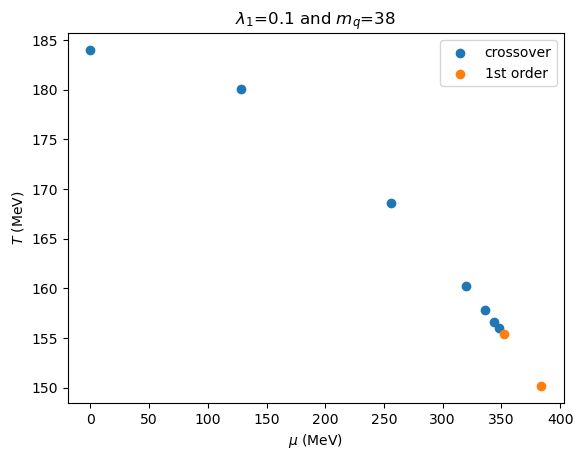

In [5]:
ml=38
lambda1=0.1
#import the data from the pickle file
df=pd.read_pickle("data/phase_plot_zoom_mq_"+str(ml)+"_lambda_"+str(lambda1)+".pkl")
#find the indices where order is 2
index=np.where(np.array(df['order'])==2)
#find the corresponding mu values
mu_cross=np.array(df['mu'])[index]
#find the corresponding Tc values
Tc_cross=np.array(df['Tc'])[index]

#find the indices where order is 1
index=np.where(np.array(df['order'])==1)
#find the corresponding mu values
mu_1storder=np.array(df['mu'])[index]
#find the corresponding Tc values
Tc_1storder=np.array(df['Tc'])[index]

#plot the results
plt.scatter(mu_cross,Tc_cross,label='crossover')
plt.scatter(mu_1storder,Tc_1storder,label='1st order')
plt.xlabel('mu')
plt.xlabel('$\mu$ (MeV)')
plt.ylabel('$T$ (MeV)')
plt.title('$\lambda_1$='+str(lambda1)+' and $m_q$='+str(ml))
plt.legend()
plt.show()

current mu value is 0


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 5.101sec
Crossover or 2nd order
Pseudo-Critical temperature is between 153.33333333333334 160.0
Iteration number  1
get_all_sigmas_parallel took 3.648sec
Crossover or 2nd order
Pseudo-Critical temperature is between 156.11111111111111 157.22222222222223
Iteration number  2
get_all_sigmas_parallel took 3.019sec
Crossover or 2nd order
Pseudo-Critical temperature is between 156.57407407407408 156.75925925925927
Iteration number  3
get_all_sigmas_parallel took 2.195sec
Crossover or 2nd order
Pseudo-Critical temperature is between 156.65123456790124 156.6820987654321
Iteration number  4
get_all_sigmas_parallel took 1.851sec
Crossover or 2nd order
Pseudo-Critical temperature is between 156.66666666666669 156.6718106995885
Iteration number  5
get_all_sigmas_parallel took 1.693sec
Crossover or 2nd order
Pseudo-Critical temperature is between 156.67138203017834 156.6718106995885
Iteration number  6
get_all_sigmas_parallel took 1.571sec
Crossover or 2nd order
Pseudo-

/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 4.859sec
Crossover or 2nd order
Pseudo-Critical temperature is between 148.33333333333334 155.0
Iteration number  1
get_all_sigmas_parallel took 3.635sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.22222222222223 153.33333333333334
Iteration number  2
get_all_sigmas_parallel took 3.090sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.82407407407408 153.00925925925927
Iteration number  3
get_all_sigmas_parallel took 2.125sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.90895061728395 152.9398148148148
Iteration number  4
get_all_sigmas_parallel took 1.734sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.92309670781893 152.92824074074073
Iteration number  5
get_all_sigmas_parallel took 1.701sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.92566872427983 152.92652606310014
Iteration number  6
get_all_sigmas_parallel took 1.656sec
Crossover or 2nd order
Pseud

/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 4.830sec
Crossover or 2nd order
Pseudo-Critical temperature is between 138.33333333333334 145.0
Iteration number  1
get_all_sigmas_parallel took 3.503sec
Crossover or 2nd order
Pseudo-Critical temperature is between 141.66666666666669 142.77777777777777
Iteration number  2
get_all_sigmas_parallel took 3.018sec
Crossover or 2nd order
Pseudo-Critical temperature is between 142.17592592592592 142.36111111111111
Iteration number  3
get_all_sigmas_parallel took 2.153sec
First order
Critical temperature is  142.29166666666666
Iteration number  4
current mu value is 192.0


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 4.882sec
Crossover or 2nd order
Pseudo-Critical temperature is between 145.0 151.66666666666666
Iteration number  1
get_all_sigmas_parallel took 3.521sec
Crossover or 2nd order
Pseudo-Critical temperature is between 147.77777777777777 148.88888888888889
Iteration number  2
get_all_sigmas_parallel took 3.021sec
Crossover or 2nd order
Pseudo-Critical temperature is between 148.28703703703704 148.47222222222223
Iteration number  3
get_all_sigmas_parallel took 2.183sec
First order
Critical temperature is  148.38734567901236
Iteration number  4
current mu value is 160.0


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 4.793sec
Crossover or 2nd order
Pseudo-Critical temperature is between 146.66666666666666 153.33333333333334
Iteration number  1
get_all_sigmas_parallel took 3.659sec
Crossover or 2nd order
Pseudo-Critical temperature is between 150.27777777777777 151.38888888888889
Iteration number  2
get_all_sigmas_parallel took 3.057sec
Crossover or 2nd order
Pseudo-Critical temperature is between 150.74074074074073 150.92592592592592
Iteration number  3
get_all_sigmas_parallel took 2.190sec
First order
Critical temperature is  150.8641975308642
Iteration number  4
current mu value is 144.0


/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 4.882sec
Crossover or 2nd order
Pseudo-Critical temperature is between 148.33333333333334 155.0
Iteration number  1
get_all_sigmas_parallel took 3.625sec
Crossover or 2nd order
Pseudo-Critical temperature is between 151.38888888888889 152.5
Iteration number  2
get_all_sigmas_parallel took 3.054sec
Crossover or 2nd order
Pseudo-Critical temperature is between 151.85185185185185 152.03703703703704
Iteration number  3
get_all_sigmas_parallel took 2.135sec
Crossover or 2nd order
Pseudo-Critical temperature is between 151.93672839506172 151.96759259259258
Iteration number  4
get_all_sigmas_parallel took 1.801sec
Crossover or 2nd order
Pseudo-Critical temperature is between 151.9457304526749 151.9508744855967
Iteration number  5
get_all_sigmas_parallel took 1.661sec
Crossover or 2nd order
Pseudo-Critical temperature is between 151.9483024691358 151.9491598079561
Iteration number  6
get_all_sigmas_parallel took 1.621sec
First order
Critical temperature is  151.948

/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 4.936sec
Crossover or 2nd order
Pseudo-Critical temperature is between 148.33333333333334 155.0
Iteration number  1
get_all_sigmas_parallel took 3.635sec
Crossover or 2nd order
Pseudo-Critical temperature is between 151.94444444444446 153.05555555555557
Iteration number  2
get_all_sigmas_parallel took 3.035sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.36111111111111 152.5462962962963
Iteration number  3
get_all_sigmas_parallel took 2.196sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.43827160493828 152.46913580246914
Iteration number  4
get_all_sigmas_parallel took 1.806sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.4485596707819 152.4537037037037
Iteration number  5
get_all_sigmas_parallel took 1.599sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.45070301783264 152.45156035665295
Iteration number  6
get_all_sigmas_parallel took 1.657sec
Crossover or 2nd order
Pseudo-

/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 4.856sec
Crossover or 2nd order
Pseudo-Critical temperature is between 148.33333333333334 155.0
Iteration number  1
get_all_sigmas_parallel took 3.526sec
Crossover or 2nd order
Pseudo-Critical temperature is between 151.66666666666669 152.77777777777777
Iteration number  2
get_all_sigmas_parallel took 2.998sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.08333333333334 152.26851851851853
Iteration number  3
get_all_sigmas_parallel took 2.149sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.18364197530866 152.21450617283952
Iteration number  4
get_all_sigmas_parallel took 1.844sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.20036008230454 152.20550411522635
Iteration number  5
get_all_sigmas_parallel took 1.815sec
Crossover or 2nd order
Pseudo-Critical temperature is between 152.20293209876544 152.20378943758575
Iteration number  6
get_all_sigmas_parallel took 1.615sec
Crossover or 2nd order
Pseu

/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/seanbartz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

get_all_sigmas_parallel took 4.395sec
Crossover or 2nd order
Pseudo-Critical temperature is between 146.66666666666666 153.33333333333334
Iteration number  1
get_all_sigmas_parallel took 3.542sec
Crossover or 2nd order
Pseudo-Critical temperature is between 150.0 151.11111111111111
Iteration number  2
get_all_sigmas_parallel took 3.039sec
Crossover or 2nd order
Pseudo-Critical temperature is between 150.50925925925927 150.69444444444446
Iteration number  3
get_all_sigmas_parallel took 2.257sec
Crossover or 2nd order
Pseudo-Critical temperature is between 150.59413580246914 150.625
Iteration number  4
get_all_sigmas_parallel took 1.687sec
Crossover or 2nd order
Pseudo-Critical temperature is between 150.59413580246914 150.59927983539094
Iteration number  5
get_all_sigmas_parallel took 1.601sec
Crossover or 2nd order
Pseudo-Critical temperature is between 150.5988511659808 150.59927983539094
Iteration number  6
get_all_sigmas_parallel took 1.662sec
Crossover or 2nd order
Pseudo-Critical 

get_all_sigmas_parallel took 2.996sec
Crossover or 2nd order
Pseudo-Critical temperature is between 130.1851851851852 130.37037037037038
Iteration number  3
get_all_sigmas_parallel took 2.141sec
Crossover or 2nd order
Pseudo-Critical temperature is between 130.2854938271605 130.31635802469137
Iteration number  4
get_all_sigmas_parallel took 1.806sec
Crossover or 2nd order
Pseudo-Critical temperature is between 130.29449588477368 130.2996399176955
Iteration number  5
get_all_sigmas_parallel took 1.650sec
Crossover or 2nd order
Pseudo-Critical temperature is between 130.29449588477368 130.29492455418384
Iteration number  6
get_all_sigmas_parallel took 1.592sec
Crossover or 2nd order
Pseudo-Critical temperature is between 130.29465663580248 130.29472808070417
Iteration number  7
current mu value is 390.0
mu value already checked. Tc= 121.66666666666667 order= 1
current mu value is 358.0
get_all_sigmas_parallel took 3.723sec
Crossover or 2nd order
Pseudo-Critical temperature is between 121

get_all_sigmas_parallel took 3.812sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 1871.0
get_all_sigmas_parallel took 3.630sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 1999.0
get_all_sigmas_parallel took 3.745sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 2127.0
get_all_sigmas_parallel took 3.549sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 2255.0
get_all_sigmas_parallel took 3.585sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 2383.0
get_all_sigmas_parallel took 3.571sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration numbe

get_all_sigmas_parallel took 3.465sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 8015.0
get_all_sigmas_parallel took 3.490sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 8143.0
get_all_sigmas_parallel took 4.329sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 8271.0
get_all_sigmas_parallel took 3.477sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 8399.0
get_all_sigmas_parallel took 3.282sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration number  1
current mu value is 8527.0
get_all_sigmas_parallel took 3.250sec
Crossover or 2nd order
Pseudo-Critical temperature is between 110.0 113.33333333333333
Iteration numbe

get_all_sigmas_parallel took 954.235sec
First order
Critical temperature is  58.333333333333336
Iteration number  1
current mu value is 8141.0
get_all_sigmas_parallel took 2.339sec
First order
Critical temperature is  58.333333333333336
Iteration number  1
current mu value is 8137.0
get_all_sigmas_parallel took 2.424sec
First order
Critical temperature is  58.333333333333336
Iteration number  1
critical_point_refined took 966.596sec
current mu value is 8130.0
get_all_sigmas_parallel took 2.372sec
First order
Critical temperature is  51.66666666666667
Iteration number  1
current mu value is 8066.0
get_all_sigmas_parallel took 2.291sec
First order
Critical temperature is  58.333333333333336
Iteration number  1
current mu value is 8034.0
get_all_sigmas_parallel took 2.476sec
First order
Critical temperature is  55.0
Iteration number  1
current mu value is 8018.0
get_all_sigmas_parallel took 2.323sec
First order
Critical temperature is  48.333333333333336
Iteration number  1
current mu val

get_all_sigmas_parallel took 2.411sec
First order
Critical temperature is  26.666666666666668
Iteration number  1
current mu value is 7086.0
get_all_sigmas_parallel took 2.394sec
Crossover or 2nd order
Pseudo-Critical temperature is between 25.0 31.666666666666668
Iteration number  1
current mu value is 7090.0
mu value already checked. Tc= 26.666666666666668 order= 1
critical_point_refined took 15.101sec
current mu value is 7083.0
get_all_sigmas_parallel took 2.396sec
First order
Critical temperature is  33.333333333333336
Iteration number  1
current mu value is 7019.0
get_all_sigmas_parallel took 2.351sec
First order
Critical temperature is  28.333333333333336
Iteration number  1
current mu value is 6987.0
get_all_sigmas_parallel took 2.393sec
Crossover or 2nd order
Pseudo-Critical temperature is between 23.333333333333336 30.0
Iteration number  1
current mu value is 7019.0
mu value already checked. Tc= 28.333333333333336 order= 1
current mu value is 7003.0
get_all_sigmas_parallel too

get_all_sigmas_parallel took 2.413sec
First order
Critical temperature is  15.0
Iteration number  1
critical_point_refined took 15.292sec
current mu value is 6000.0
get_all_sigmas_parallel took 2.333sec
First order
Critical temperature is  20.0
Iteration number  1
current mu value is 5936.0
get_all_sigmas_parallel took 2.406sec
First order
Critical temperature is  15.0
Iteration number  1
current mu value is 5904.0
get_all_sigmas_parallel took 2.429sec
First order
Critical temperature is  16.666666666666668
Iteration number  1
current mu value is 5888.0
get_all_sigmas_parallel took 2.536sec
First order
Critical temperature is  15.0
Iteration number  1
current mu value is 5880.0
get_all_sigmas_parallel took 2.562sec
First order
Critical temperature is  15.0
Iteration number  1
current mu value is 5876.0
get_all_sigmas_parallel took 2.426sec
First order
Critical temperature is  15.0
Iteration number  1
critical_point_refined took 15.338sec
current mu value is 5869.0
get_all_sigmas_parall

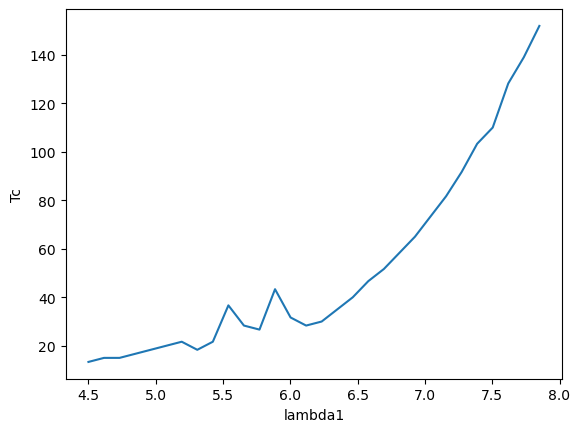

In [3]:
ml=24
a0=0
minsigma=0
maxsigma=400
tmin=120
tmax=160
numtemp=25
# create an array of lambda1 values, and find the critical point for each of them
lambda1_array=np.linspace(7.85, 4.5, 30)
Tc_array=np.zeros(len(lambda1_array))
mu_array=np.zeros(len(lambda1_array))
mu_precision=4
delta_mu=128
mu_min=0

for i in range(0,len(lambda1_array)):
    mu,Tc,sigma_peak=critical_point_refined(lambda1_array[i],ml,a0,tmin,tmax,numtemp,minsigma,maxsigma,mu_min,delta_mu,mu_precision)
    Tc_array[i]=Tc
    mu_array[i]=mu
    #adjust the search window for the next value
    mu_min=max(0,mu-5)
    if Tc<tmin+10:
        tmin=max(0,tmin-10)
        tmax=max(tmin+20,tmax-10)
    if sigma_peak+50<maxsigma:
        maxsigma=max(100,maxsigma-50)

plt.plot(lambda1_array,Tc_array)
plt.xlabel("lambda1")
plt.ylabel("Tc")
plt.show()

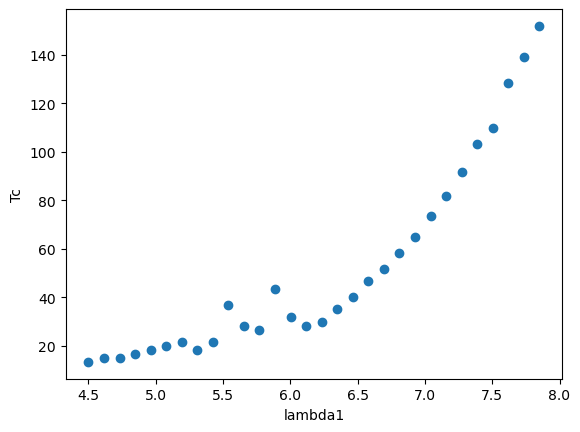

In [4]:
plt.scatter(lambda1_array,Tc_array)
plt.xlabel("lambda1")
plt.ylabel("Tc")
plt.show()

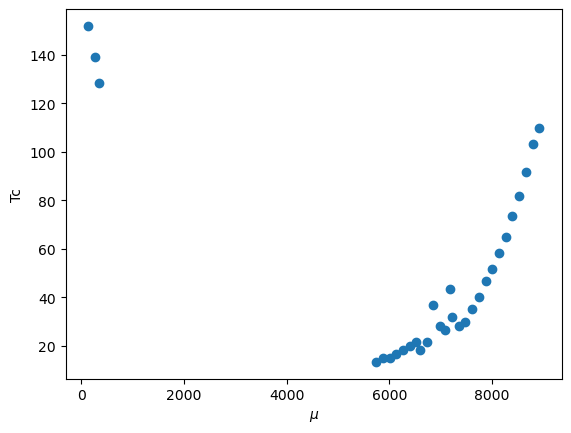

In [8]:
plt.scatter(mu_array,Tc_array)
plt.xlabel("$\mu$")
plt.ylabel("Tc")
plt.show()

In [6]:
Tc_array

array([151.94876686, 139.01727538, 128.22293905, 110.01736111,
       103.33333333,  91.66666667,  81.66666667,  73.33333333,
        65.        ,  58.33333333,  51.66666667,  46.66666667,
        40.        ,  35.        ,  30.        ,  28.33333333,
        31.66666667,  43.33333333,  26.66666667,  28.33333333,
        36.66666667,  21.66666667,  18.33333333,  21.66666667,
        20.        ,  18.33333333,  16.66666667,  15.        ,
        15.        ,  13.33333333])

In [9]:
mu_array

array([ 142.,  267.,  340., 8921., 8790., 8659., 8528., 8397., 8266.,
       8135., 8004., 7873., 7742., 7611., 7480., 7349., 7218., 7183.,
       7088., 6989., 6858., 6727., 6596., 6529., 6398., 6267., 6136.,
       6005., 5874., 5743.])